<a href="https://colab.research.google.com/github/SvgPrizrak/ML_Sber_Homework/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22hw05_trees_forest_boosting%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ДЗ 5. Решающие деревья, леса, бустинги

В рамках этого ДЗ вам предлагается решить задачу кредитного скоринга с соревнования на [Kaggle](https://inclass.kaggle.com/c/beeline-credit-scoring-competition-2), используя "древесные" модели классификации.

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Предобработка данных

In [ ]:
!gdown 1RT9638iIwAP3JmdgPcxHN15NvsAHf7am

Downloading...
From: https://drive.google.com/uc?id=1RT9638iIwAP3JmdgPcxHN15NvsAHf7am
To: /content/credit_scoring_train.csv
100% 3.95M/3.95M [00:00<00:00, 93.5MB/s]


In [ ]:
train_df = pd.read_csv('credit_scoring_train.csv', index_col='client_id')

Признаки клиентов банка:
- `Age` - возраст (вещественный)
- `Income` - месячный доход (вещественный)
- `BalanceToCreditLimit` - отношение баланса на кредитной карте к лимиту по кредиту (вещественный)
- `DIR` - Debt-to-income Ratio (вещественный)
- `NumLoans` - число заемов и кредитных линий
- `NumRealEstateLoans` - число ипотек и заемов, связанных с недвижимостью (натуральное число)
- `NumDependents` - число членов семьи, которых содержит клиент, исключая самого клиента (натуральное число)
- `Num30-59Delinquencies` - число просрочек выплат по кредиту от 30 до 59 дней (натуральное число)
- `Num60-89Delinquencies` - число просрочек выплат по кредиту от 60 до 89 дней (натуральное число)
- `Delinquent90` - были ли просрочки выплат по кредиту более 90 дней (бинарный) - имеется только в обучающей выборке

### Знакомство с данными

Ознакомимся с данными:

In [ ]:
train_df.head()

,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit,Delinquent90
client_id,,,,,,,,,,
0,0.496289,49.1,13,0,0.0,2,0,5298.360639,0.387028,0
1,0.433567,48.0,9,2,2.0,1,0,6008.056256,0.234679,0
2,2206.731199,55.5,21,1,NaN,1,0,NaN,0.348227,0
3,886.132793,55.3,3,0,0.0,0,0,NaN,0.971930,0
4,0.000000,52.3,1,0,0.0,0,0,2504.613105,1.004350,0


In [ ]:
train_df.describe()

,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit,Delinquent90
count,75000.000000,75000.000000,75000.00000,75000.000000,73084.000000,75000.000000,75000.000000,6.015300e+04,75000.000000,75000.000000
mean,353.260293,52.595605,8.44976,1.016693,0.755966,0.428320,0.248000,6.740059e+03,6.276196,0.066840
std,2117.237432,14.869729,5.15644,1.124019,1.108119,4.276439,4.239486,1.422875e+04,267.743321,0.249746
min,0.000000,21.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.176022,41.300000,5.00000,0.000000,0.000000,0.000000,0.000000,3.421354e+03,0.029703,0.000000
50%,0.366848,52.200000,8.00000,1.000000,0.000000,0.000000,0.000000,5.424552e+03,0.153720,0.000000
75%,0.862650,63.100000,11.00000,2.000000,1.000000,0.000000,0.000000,8.291518e+03,0.560638,0.000000
max,332600.272820,109.800000,56.00000,32.000000,20.000000,98.000000,98.000000,1.805573e+06,50873.874533,1.000000


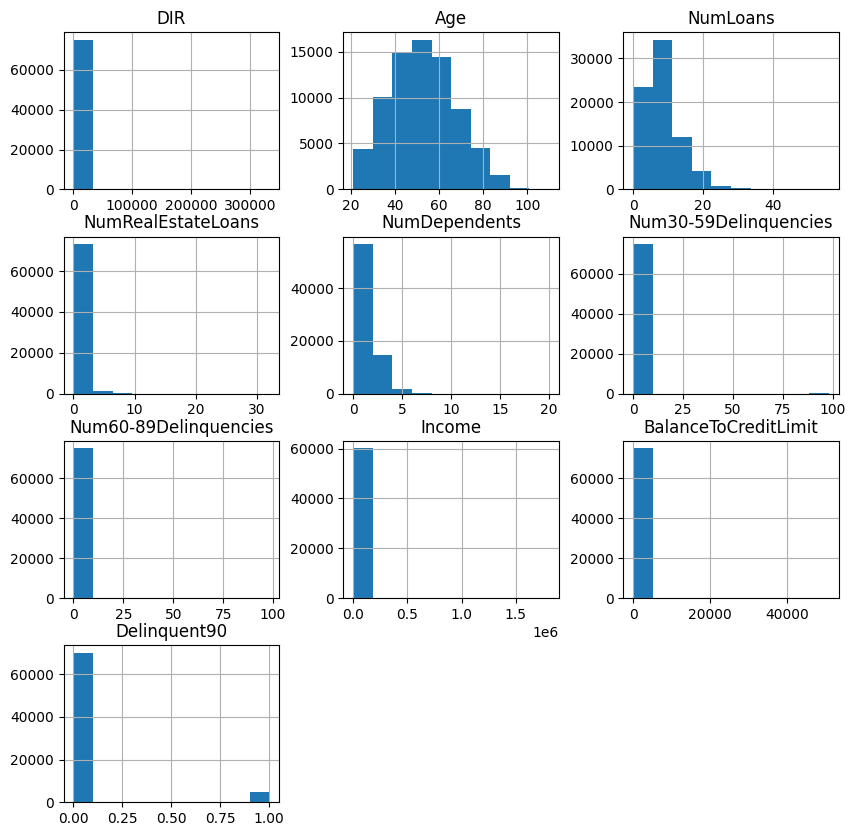

In [ ]:
# подгоним графики под масштаб
fig=plt.figure(figsize=(10, 10))
ax = fig.gca()
hists = train_df.hist(ax=ax, bins=10)

В качестве целевого признака используем колонку `Delinquent90` - просрочившие больше чем на 90 дней.

Отделите выделите из обучающего датасета целевой признак `y` и матрицу "объекты-признаки" `X`:

In [ ]:
y = train_df['Delinquent90']
X = train_df.drop('Delinquent90', axis=1)

Посмотрите на количество объектов каждого из классов:

In [ ]:
# ваш код здесь

# мы видим дисбаланс классов - доля правильных ответов явно не будет лучшей метрикой
y.value_counts()

0    69987
1     5013
Name: Delinquent90, dtype: int64

In [ ]:
# поскольку 0 больше, чем 1, то базовое решение будет 1 - среднее значение целевой метрики
1 - y.mean()

0.93316

In [ ]:
69987 / (69987 + 5013)

0.93316

- Какие выводы можно сделать?
- Какое из значений метрики `accuracy` можно считать за базовое решение, которое будем пытаться побить?
- Насколько нам подходит метрика accuracy? Какие знаете более подходящие метрики?

**Ваши ответы здесь:**

- Дисбаланс (перекос в сторону) классов в сторону класса  `0` - логично, что просрочки невыгодны клиентам, потому их явно будет меньше в данных, задача бинарной классификации;
- 0.93316 - см. ячейку выше - фактически это `accuracy` классификатора, который показывает только метки `0`;
- не подойдет, описано выше почему (классификатор, выдающий только `0` уже кажется неплохим, но это не так); из-за дисбаланса классов лучше всего взять `F1-score` (или по отдельности смотреть `precision` и `recall`), `Precision-Recall AUC`, `ROC-AUC`.

### Заполнение пропусков - 1 балл

Продолжим предобработку данных. Посчитайте сколько пропусков в каждом из признаков:

In [ ]:
# ваш код здесь
X.isna().sum(), y.isna().sum()

(DIR                          0
 Age                          0
 NumLoans                     0
 NumRealEstateLoans           0
 NumDependents             1916
 Num30-59Delinquencies        0
 Num60-89Delinquencies        0
 Income                   14847
 BalanceToCreditLimit         0
 dtype: int64,
 0)

Заполните пропуски медианными значениями:

In [ ]:
# ваш код здесь
X.fillna(train_df.median(), inplace=True)

Проверьте еще раз количество оставшихся пропусков:

In [ ]:
# ваш код здесь - пропусков больше нет
X.isna().sum(), y.isna().sum()

(DIR                      0
 Age                      0
 NumLoans                 0
 NumRealEstateLoans       0
 NumDependents            0
 Num30-59Delinquencies    0
 Num60-89Delinquencies    0
 Income                   0
 BalanceToCreditLimit     0
 dtype: int64,
 0)

### Нормировка - 1 балл

Выполним масштабирование наших признаков так, чтобы их значение находилось в диапазоне `[0, 1]`:

In [ ]:
# перед обучением следует разделить датасет на обучающую и валидационную части
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, random_state=42, stratify=y)

# импорт и инициализация класса MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# трансформируйте все признаки, если затрудняетесь - посмотрите в документации sklearn
# хорошая практика это fit_transform на train и transform на test
X_train_scaled_df = scaler.fit_transform(X_train)
X_valid_scaled_df = scaler.transform(X_valid)
X_train_scaled_df = pd.DataFrame(X_train_scaled_df, columns = X.columns)
X_valid_scaled_df = pd.DataFrame(X_valid_scaled_df, columns = X.columns)
X_train_scaled_df

,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit
0,1.300635e-01,0.226862,0.196429,0.18750,0.05,0.000000,0.0,0.003004,0.000000e+00
1,8.076215e-06,0.252822,0.178571,0.03125,0.15,0.000000,0.0,0.003327,0.000000e+00
2,1.012332e-01,0.341986,0.232143,0.06250,0.20,0.010204,0.0,0.003004,4.557681e-05
3,1.310377e-05,0.352144,0.321429,0.06250,0.15,0.000000,0.0,0.006775,1.565118e-05
4,1.323345e-07,0.554176,0.178571,0.00000,0.00,0.000000,0.0,0.005515,8.887895e-07
...,...,...,...,...,...,...,...,...,...
52495,3.771193e-06,0.125282,0.107143,0.00000,0.05,0.010204,0.0,0.002792,2.883540e-05
52496,4.135569e-07,0.620767,0.053571,0.00000,0.00,0.000000,0.0,0.001672,3.032618e-06
52497,1.149359e-05,0.372460,0.125000,0.03125,0.00,0.000000,0.0,0.002892,2.370435e-05
52498,2.928004e-06,0.444695,0.142857,0.06250,0.20,0.000000,0.0,0.021988,1.177965e-06


Удостоверьтесь, что теперь значения всех признаков находятся в диапазоне `[0,1]`:

In [ ]:
# ваш код здесь - процент в каждой колонке, который подходит под условие нормировки (обучающая часть)
X_train_scaled_df[(X_train_scaled_df >= 0) & (X_train_scaled_df <= 1)].count() * 100 / X_train_scaled_df.shape[0]

DIR                      100.0
Age                      100.0
NumLoans                 100.0
NumRealEstateLoans       100.0
NumDependents            100.0
Num30-59Delinquencies    100.0
Num60-89Delinquencies    100.0
Income                   100.0
BalanceToCreditLimit     100.0
dtype: float64

In [ ]:
# ваш код здесь - процент в каждой колонке, который подходит под условие нормировки (валидационная часть) - часть из них может выходить из диапазона, потому что выходит вне диапазона X_train
X_valid_scaled_df[(X_valid_scaled_df >= 0) & (X_valid_scaled_df <= 1)].count() * 100 / X_valid_scaled_df.shape[0]

DIR                       99.982222
Age                       99.995556
NumLoans                 100.000000
NumRealEstateLoans       100.000000
NumDependents            100.000000
Num30-59Delinquencies    100.000000
Num60-89Delinquencies    100.000000
Income                   100.000000
BalanceToCreditLimit      99.995556
dtype: float64

# Обучение моделей

## Дерево решений - 2 балла

Обучите решающее дерево, значения гиперпараметров выберите на ваш вкус, подбирать их не нужно:

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# ваш код здесь
dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=3, min_samples_split=2, min_samples_leaf=2, random_state=17)
dt.fit(X_train, y_train)
y_train_pred, y_valid_pred = dt.predict(X_train), dt.predict(X_valid)
y_train_pred_proba, y_valid_pred_proba = dt.predict_proba(X_train), dt.predict_proba(X_valid)

Получите предсказания вашей модели и проверьте как она обучилась с помощью метрик `f1_score`, `accuracy_score`, `roc_auc_score`, `mean_squared_error`:

In [ ]:
from sklearn import metrics

# ваш код здесь
print(f'F1-score на валидационной части : {metrics.f1_score(y_true=y_valid, y_pred=y_valid_pred)}')
print(f'Accuracy на валидационной части : {metrics.accuracy_score(y_true=y_valid, y_pred=y_valid_pred)}')
print(f'ROC-AUC score на валидационной части : {metrics.roc_auc_score(y_true=y_valid, y_score=y_valid_pred_proba[:, 1])}')
print(f'MSE на валидационной части (?) : {metrics.mean_squared_error(y_true=y_valid, y_pred=y_valid_pred)}')

F1-score на валидационной части : 0.08850645359557469
Accuracy на валидационной части : 0.9340888888888889
ROC-AUC score на валидационной части : 0.7930534450837646
MSE на валидационной части (?) : 0.06591111111111111


Проверьте, не переобучились ли вы - сравните значения метрик на обучающей и валидационной выборках:

In [ ]:
# ваш код здесь - в целом метрики выше на обучающей части незначительно выше, но говорить что модель сильно переобучена нельзя
print(f'F1-score на обучающей части : {metrics.f1_score(y_true=y_train, y_pred=y_train_pred)}')
print(f'Accuracy на обучающей части : {metrics.accuracy_score(y_true=y_train, y_pred=y_train_pred)}')
print(f'ROC-AUC score на обучающей части : {metrics.roc_auc_score(y_true=y_train, y_score=y_train_pred_proba[:, 1])}')
print(f'MSE на обучающей части (?) : {metrics.mean_squared_error(y_true=y_train, y_pred=y_train_pred)}')

F1-score на обучающей части : 0.08879492600422834
Accuracy на обучающей части : 0.9343238095238096
ROC-AUC score на обучающей части : 0.8058317473576012
MSE на обучающей части (?) : 0.06567619047619047


## Дерево решений + `GridSearch` - 2 балла

Выберите 2 гиперпараметра и по 3-5 значений для каждого из них:

In [ ]:
from sklearn.model_selection import GridSearchCV

# ваш код здесь - для каждой из метрик лучше обучить свой классификатор, потому что есть параметр scoring
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'], 'splitter': ['best', 'random'], 'max_depth': np.arange(1, 6),
              'min_samples_split': np.arange(1, 5), 'min_samples_leaf': np.arange(1, 4)}

# все estimators (поскольку по умолчанию refit=True, то нет смысла брать best_estimator для обучения на всей тестовой части - GridSearchCV сделает это автоматически)
f1_clf = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='f1')
acurracy_clf = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy')
roc_auc_clf = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='roc_auc')
mse_clf = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')


for i_estimator in [f1_clf, acurracy_clf, roc_auc_clf, mse_clf]:
    i_estimator.fit(X_train, y_train)
    y_f1_train_pred, y_f1_valid_pred = i_estimator.predict(X_train), i_estimator.predict(X_valid)
    y_f1_train_pred_proba, y_f1_valid_pred_proba = i_estimator.predict_proba(X_train), i_estimator.predict_proba(X_valid)

    if i_estimator == f1_clf:
        print(f'F1-score на обучающей части : {metrics.f1_score(y_true=y_train, y_pred=y_f1_train_pred)}')
        print(f'F1-score на валидационной части : {metrics.f1_score(y_true=y_valid, y_pred=y_f1_valid_pred)}')
        print('-' * 75)
    elif i_estimator == acurracy_clf:
        print(f'Accuracy на обучающей части : {metrics.accuracy_score(y_true=y_train, y_pred=y_f1_train_pred)}')
        print(f'Accuracy на валидационной части : {metrics.accuracy_score(y_true=y_valid, y_pred=y_f1_valid_pred)}')
        print('-' * 75)
    elif i_estimator == roc_auc_clf:
        print(f'ROC-AUC на обучающей части : {metrics.roc_auc_score(y_true=y_train, y_score=y_train_pred_proba[:, 1])}')
        print(f'ROC-AUC на валидационной части : {metrics.roc_auc_score(y_true=y_valid, y_score=y_valid_pred_proba[:, 1])}')
        print('-' * 75)
    else:
        print(f'MSE на обучающей части (?): {metrics.mean_squared_error(y_true=y_train, y_pred=y_train_pred)}')
        print(f'ROC-AUC на валидационной части (?): {metrics.mean_squared_error(y_true=y_valid, y_pred=y_valid_pred)}')
        print('-' * 75)

F1-score на обучающей части : 0.1671583087512291
F1-score на валидационной части : 0.14857142857142858
---------------------------------------------------------------------------
Accuracy на обучающей части : 0.936247619047619
Accuracy на валидационной части : 0.9334222222222223
---------------------------------------------------------------------------
ROC-AUC на обучающей части : 0.8058317473576012
ROC-AUC на валидационной части : 0.7930534450837646
---------------------------------------------------------------------------
MSE на обучающей части (?): 0.06567619047619047
ROC-AUC на валидационной части (?): 0.06591111111111111
---------------------------------------------------------------------------


Сравните значения метрик. Какой получили прирост?

Наибольший прирост метрик виден в метрике `F1-score`. В остальных метриках прирост если и наблюдается, то он незначительный (метрика `MSE` для классификации не является целевой, `accuracy` из-за дисбаланса классов не может получить значительный прирост, `ROC-AUC` полностью совпал как на обучающей, так и на валидационной частях).

## Случайный лес - 2 балла

Обучите модель случайного леса:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# ваш код здесь
rf = RandomForestClassifier(n_estimators=500, criterion='gini', max_features='sqrt', max_depth=5, min_samples_split=2, min_samples_leaf=1, random_state=17)
rf.fit(X_train, y_train)
y_train_pred, y_valid_pred = rf.predict(X_train), rf.predict(X_valid)
y_train_pred_proba, y_valid_pred_proba = rf.predict_proba(X_train), rf.predict_proba(X_valid)

Аналогично, посчитайте значение метрик:

In [ ]:
# ваш код здесь
print(f'F1-score на валидационной части : {metrics.f1_score(y_true=y_valid, y_pred=y_valid_pred)}')
print(f'Accuracy на валидационной части : {metrics.accuracy_score(y_true=y_valid, y_pred=y_valid_pred)}')
print(f'ROC-AUC score на валидационной части : {metrics.roc_auc_score(y_true=y_valid, y_score=y_valid_pred_proba[:, 1])}')
print(f'MSE на валидационной части (?) : {metrics.mean_squared_error(y_true=y_valid, y_pred=y_valid_pred)}')

F1-score на валидационной части : 0.09102244389027431
Accuracy на валидационной части : 0.9352
ROC-AUC score на валидационной части : 0.8323510455892308
MSE на валидационной части (?) : 0.0648


И проверьте на переобучение:

In [ ]:
# ваш код здесь - в целом метрики выше на обучающей части выше, модель можно считать переобученной, что для одного дерева логично
print(f'F1-score на обучающей части : {metrics.f1_score(y_true=y_train, y_pred=y_train_pred)}')
print(f'Accuracy на обучающей части : {metrics.accuracy_score(y_true=y_train, y_pred=y_train_pred)}')
print(f'ROC-AUC score на обучающей части : {metrics.roc_auc_score(y_true=y_train, y_score=y_train_pred_proba[:, 1])}')
print(f'MSE на обучающей части (?) : {metrics.mean_squared_error(y_true=y_train, y_pred=y_train_pred)}')

F1-score на обучающей части : 0.10543046357615894
Accuracy на обучающей части : 0.9356761904761904
ROC-AUC score на обучающей части : 0.8522513853647542
MSE на обучающей части (?) : 0.06432380952380952


Какие выводы можем сделать при сравнении случайного леса и одного решающего дерева?

**Ваш ответ здесь:**

Обучение рандомного леса выдаст лучшие метрики при предсказании, нежели при обучении одного случайного дерева (что в принципе логично). Более того, предсказание случайного леса без подбора гиперпараметров может показать лучшие или схожие метрики при предсказании дерева решений с их подбором (в нашем случае лучше всего смотреть на `ROC-AUC score`, хоть есть и проигрыш в `F1-score`). В теории, мы должны были заметить меньшее переобучение, однако на данном примере это не столь сильно заметно.

## Градиентный бустинг - 2 балла

С помощью библиотеки LightGBM обучим градиентный бустинг на решающих деревьях:

In [ ]:
from lightgbm import LGBMClassifier

# ваш код здесь
lgmb_clf = LGBMClassifier(boosting_type='gbdt', num_leaves=10,
                          max_depth=5, learning_rate=0.1, n_estimators=50, force_row_wise=True)
lgmb_clf.fit(X_train, y_train)

y_train_pred, y_valid_pred = lgmb_clf.predict(X_train), lgmb_clf.predict(X_valid)
y_train_pred_proba, y_valid_pred_proba = lgmb_clf.predict_proba(X_train), lgmb_clf.predict_proba(X_valid)

[LightGBM] [Info] Number of positive: 3509, number of negative: 48991
[LightGBM] [Info] Total Bins 1116
[LightGBM] [Info] Number of data points in the train set: 52500, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066838 -> initscore=-2.636306
[LightGBM] [Info] Start training from score -2.636306


Аналогично, посмотрим на метрики:

In [ ]:
# ваш код здесь
print(f'F1-score на обучающей части : {metrics.f1_score(y_true=y_train, y_pred=y_train_pred)}')
print(f'Accuracy на обучающей части : {metrics.accuracy_score(y_true=y_train, y_pred=y_train_pred)}')
print(f'ROC-AUC score на обучающей части : {metrics.roc_auc_score(y_true=y_train, y_score=y_train_pred_proba[:, 1])}')
print(f'MSE на обучающей части (?) : {metrics.mean_squared_error(y_true=y_train, y_pred=y_train_pred)}')
print('-' * 75)
print(f'F1-score на валидационной части : {metrics.f1_score(y_true=y_valid, y_pred=y_valid_pred)}')
print(f'Accuracy на валидационной части : {metrics.accuracy_score(y_true=y_valid, y_pred=y_valid_pred)}')
print(f'ROC-AUC score на валидационной части : {metrics.roc_auc_score(y_true=y_valid, y_score=y_valid_pred_proba[:, 1])}')
print(f'MSE на валидационной части (?) : {metrics.mean_squared_error(y_true=y_valid, y_pred=y_valid_pred)}')

F1-score на обучающей части : 0.2045400238948626
Accuracy на обучающей части : 0.9365904761904762
ROC-AUC score на обучающей части : 0.8608352780251092
MSE на обучающей части (?) : 0.0634095238095238
---------------------------------------------------------------------------
F1-score на валидационной части : 0.2007764836383805
Accuracy на валидационной части : 0.9359555555555555
ROC-AUC score на валидационной части : 0.8374674425067794
MSE на валидационной части (?) : 0.06404444444444445


Какие выводы можем сделать при сравнении случайного леса и градиентного бустинга? Что заметили?

**Ваш ответ здесь:**

При простом подборе гиперпараметров `LightGBM` (или иного другого бустинга, без `GridSearch`) можно подобрать более "хорошие" метрики на предсказании, нежели дня случайного леса и тем более одного дерева решений. На примере видно, что ВСЕ метрики на тестовом и валидационном датасете достаточно близки, т.е. модель не переобучена. Более того, их абсолютные значения при обучении градиентного бустинга НЕ ХУЖЕ, чем для случайного леса.

Из исследованных примеров: одно дерево (наравне с логистической регрессией) может служить `baseline`, случайный лес и градиентный бустинг следует сравнивать между собой (для <u>табличных данных</u> зачастую выигрывает бустинг, учитывая, что он может быть построен на этих самых деревьях или случайном лесе).